# Wind Power Prediction Using Temporal Fusion Transformer

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.metrics import mean_squared_error
import kagglehub
import seaborn as sns
# PyTorch Lightning and Forecasting
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from sklearn.preprocessing import MinMaxScaler

# PyTorch Forecasting
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss, MAE, RMSE, SMAPE

# Set random seeds for reproducibility
pl.seed_everything(42)

Seed set to 42


42

In [32]:
path = kagglehub.dataset_download("mubashirrahim/wind-power-generation-data-forecasting")
data = pd.read_csv(path + "/Location1.csv")


In [33]:
data.describe()

,temperature_2m,relativehumidity_2m,dewpoint_2m,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,Power
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,47.862911,72.288744,38.569308,3.591147,6.284431,203.637329,203.343676,7.771795,0.405385
std,19.453691,16.852287,18.772110,1.649318,2.685216,96.371262,97.959852,3.569147,0.288322
min,-14.400000,18.000000,-17.100000,0.000000,0.100000,1.000000,0.000000,0.500000,0.000000
25%,32.100000,60.000000,24.300000,2.410000,4.380000,132.000000,130.000000,5.000000,0.148900
50%,47.300000,74.000000,38.100000,3.300000,6.080000,225.000000,226.000000,7.200000,0.347650
75%,64.500000,86.000000,54.700000,4.590000,7.990000,277.000000,278.000000,10.000000,0.659600
max,94.100000,100.000000,76.300000,13.450000,20.650000,360.000000,360.000000,29.200000,0.991300


In [34]:
print(tabulate(data.head(), headers='keys', tablefmt='psql'))

+----+---------------------+------------------+-----------------------+---------------+-----------------+------------------+---------------------+----------------------+-----------------+---------+
|    | Time                |   temperature_2m |   relativehumidity_2m |   dewpoint_2m |   windspeed_10m |   windspeed_100m |   winddirection_10m |   winddirection_100m |   windgusts_10m |   Power |
|----+---------------------+------------------+-----------------------+---------------+-----------------+------------------+---------------------+----------------------+-----------------+---------|
|  0 | 2017-01-02 00:00:00 |             28.5 |                    85 |          24.5 |            1.44 |             1.26 |                 146 |                  162 |             1.4 |  0.1635 |
|  1 | 2017-01-02 01:00:00 |             28.4 |                    86 |          24.7 |            2.06 |             3.99 |                 151 |                  158 |             4.4 |  0.1424 |
|  2 | 201

In [35]:
# Handle missing values
data.isnull().sum()
data = data.ffill().bfill()

In [36]:
cols = ['temperature_2m','relativehumidity_2m','dewpoint_2m','windspeed_10m','winddirection_10m','windspeed_100m','winddirection_10m','winddirection_100m','windgusts_10m','Power']
scaler = MinMaxScaler()
data[cols] = scaler.fit_transform(data[cols])
print(tabulate(data.head(), headers='keys', tablefmt='psql'))

+----+---------------------+------------------+-----------------------+---------------+-----------------+------------------+---------------------+----------------------+-----------------+----------+
|    | Time                |   temperature_2m |   relativehumidity_2m |   dewpoint_2m |   windspeed_10m |   windspeed_100m |   winddirection_10m |   winddirection_100m |   windgusts_10m |    Power |
|----+---------------------+------------------+-----------------------+---------------+-----------------+------------------+---------------------+----------------------+-----------------+----------|
|  0 | 2017-01-02 00:00:00 |         0.395392 |              0.817073 |      0.445396 |       0.107063  |        0.0564477 |            0.4039   |             0.45     |       0.0313589 | 0.164935 |
|  1 | 2017-01-02 01:00:00 |         0.39447  |              0.829268 |      0.447537 |       0.15316   |        0.189294  |            0.417827 |             0.438889 |       0.135889  | 0.14365  |
|  2 

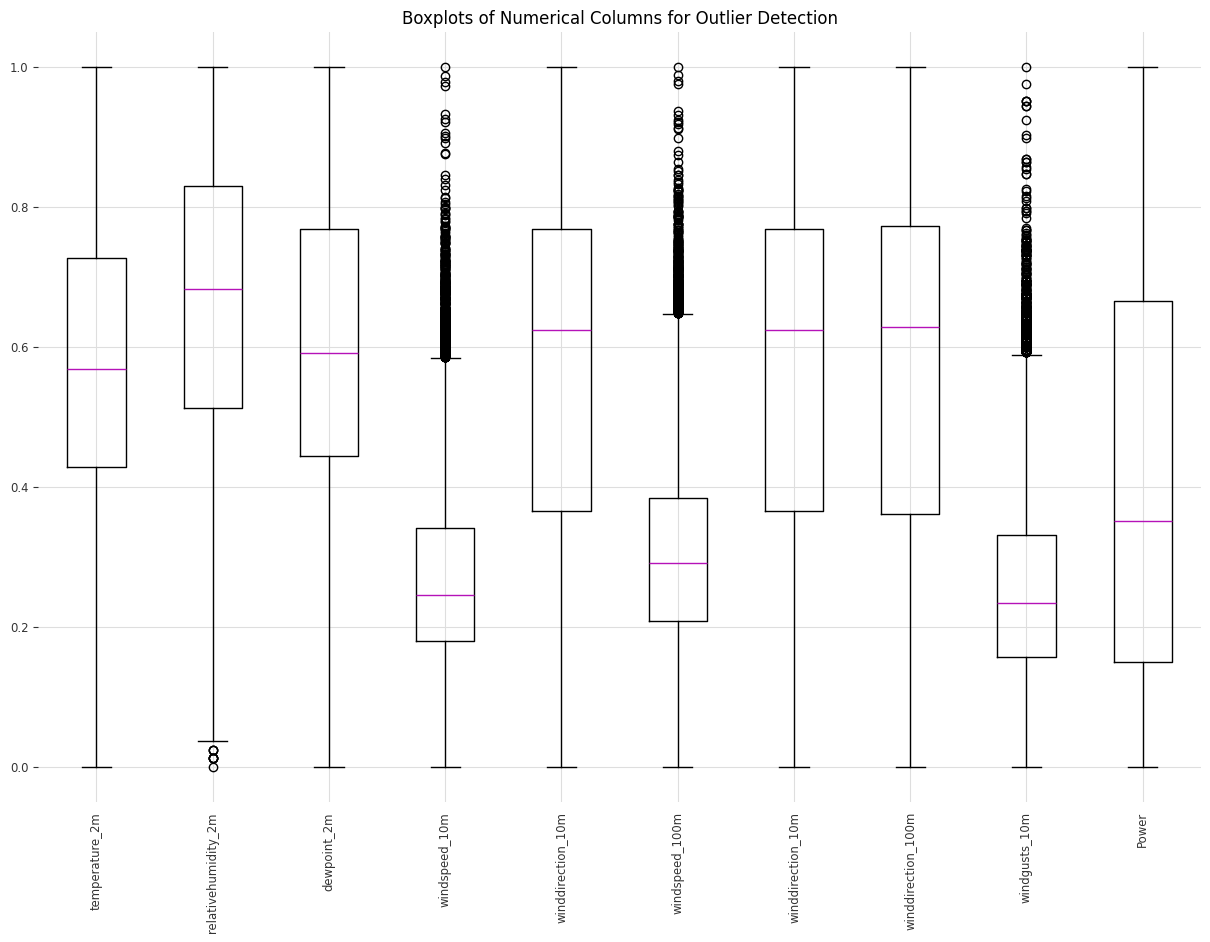

In [39]:
plt.figure(figsize=(15, 10))
data[cols].boxplot()
plt.xticks(rotation=90)
plt.title('Boxplots of Numerical Columns for Outlier Detection')
plt.show()

In [40]:
# Calculating Q1, Q3, and IQR for each numerical column
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

# Defining the boundaries for detecting outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtering out rows that contain outliers beyond the IQR boundaries
outliers_filtered_data = data[~((data < lower_bound) | (data > upper_bound)).any(axis=1)]

# Displaying the shape of the data before and after outlier removal
data_shape_before = data.shape
data_shape_after = outliers_filtered_data.shape

data_shape_before, data_shape_after

TypeError: unsupported operand type(s) for -: 'str' and 'str'